In [1]:
!pip install pandas

Access is denied.


In [3]:
import pandas as pd

In [8]:
df=pd.read_csv(r"C:\Users\kiran\Desktop\os el\csv files\updated_can_dataset.csv")

In [11]:
df.describe()

,Timestamp,CAN ID,DLC,data1,data2,data3,data4,data5,data6,data7,data8,SecondsSinceStart
count,1.656948e+07,1.656948e+07,1.656948e+07,1.656948e+07,1.656948e+07,1.656948e+07,1.656948e+07,1.656948e+07,1.656948e+07,1.656948e+07,1.656948e+07,1.656948e+07
mean,1.478197e+09,7.048842e+02,7.937015e+00,3.049707e+02,1.943530e+02,8.110012e+01,1.771227e+02,1.121730e+02,1.342131e+02,5.539590e+01,1.187633e+02,5.501790e+03
std,3.447091e+03,3.977546e+02,5.872882e-01,5.273629e+02,2.862775e+02,1.303835e+02,2.415236e+02,1.726643e+02,1.828051e+02,1.305977e+02,1.878880e+02,3.447091e+03
min,1.478191e+09,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.478193e+09,3.390000e+02,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.379954e+03
50%,1.478196e+09,7.900000e+02,8.000000e+00,8.000000e+00,8.000000e+01,0.000000e+00,3.200000e+01,2.100000e+01,5.000000e+01,0.000000e+00,0.000000e+00,5.404913e+03
75%,1.478200e+09,1.072000e+03,8.000000e+00,2.610000e+02,2.610000e+02,1.500000e+02,3.110000e+02,2.630000e+02,2.950000e+02,9.000000e+00,2.640000e+02,9.214713e+03
max,1.478201e+09,2.047000e+03,8.000000e+00,1.431000e+03,1.431000e+03,5.970000e+02,5.970000e+02,5.970000e+02,5.970000e+02,5.970000e+02,5.970000e+02,1.017901e+04


**➤ 1. Windowing (fixed time windows, e.g., 60 seconds)**

In [10]:
import pandas as pd

# Ensure proper datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set time as index
df = df.set_index('Datetime')

# Define window size (e.g., 60s)
windowed = [group for _, group in df.groupby(pd.Grouper(freq='60S'))]


C:\Users\kiran\AppData\Local\Temp\ipykernel_17352\1046381113.py:10: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  windowed = [group for _, group in df.groupby(pd.Grouper(freq='60S'))]


**➤ 2. Feature Functions (to apply per window)**

In [23]:
import numpy as np
from scipy.stats import entropy

def compute_features(window, debug=False):
    if len(window) == 0:
        if debug: print("⚠️ Skipped empty window.")
        return None

    features = {}

    # --- Inter-Arrival Time ---
    timestamps = window['Timestamp'].values
    inter_arrival = np.diff(timestamps)
    features['iat_mean'] = np.mean(inter_arrival) if len(inter_arrival) > 0 else 0
    features['iat_std'] = np.std(inter_arrival) if len(inter_arrival) > 0 else 0

    # --- Payload Entropy ---
    payload_cols = [f'data{i}' for i in range(1, 9)]
    payload_bytes = window[payload_cols].values.flatten()
    payload_bytes = payload_bytes[payload_bytes > 0]  # Remove padding zeros
    if len(payload_bytes) > 0:
        value_counts = np.bincount(payload_bytes, minlength=256)
        probs = value_counts / value_counts.sum()
        features['payload_entropy'] = entropy(probs, base=2)
    else:
        features['payload_entropy'] = 0

    # --- Bit Flips Between Consecutive Payloads ---
    data_array = window[payload_cols].to_numpy(dtype=np.uint8)
    bit_flips = []
    for i in range(1, len(data_array)):
        flips = np.sum(
            np.unpackbits(data_array[i-1]) != np.unpackbits(data_array[i])
        )
        bit_flips.append(flips)
    features['bit_flips_mean'] = np.mean(bit_flips) if bit_flips else 0

    # --- 0 Payload Ratio ---
    zero_payloads = np.sum(np.all(data_array == 0, axis=1))
    features['zero_payload_ratio'] = zero_payloads / len(data_array)

    # --- Repetitive Bytes ---
    repetitive = np.mean([len(set(row)) < 3 for row in data_array])
    features['repetitive_bytes_ratio'] = repetitive

    # --- Duplicate Messages ---
    duplicates = window.duplicated(subset=['CAN ID'] + payload_cols).sum()
    features['duplicate_count'] = duplicates

    # --- Frequency Per Second ---
    if hasattr(window.index[0], 'to_datetime64'):
        duration = (window.index[-1] - window.index[0]).total_seconds()
    else:
        duration = window['Timestamp'].iloc[-1] - window['Timestamp'].iloc[0]
    features['frequency_per_sec'] = len(window) / duration if duration > 0 else 0

    # --- CAN ID Entropy ---
    canid_counts = window['CAN ID'].value_counts()
    canid_probs = canid_counts / canid_counts.sum()
    features['canid_entropy'] = entropy(canid_probs, base=2)

    # ✅ Top 3 CAN IDs in the window
    top_ids = window['CAN ID'].value_counts().head(3)

    for i, (can_id, freq) in enumerate(top_ids.items()):
        features[f'canid_{i}_val'] = int(can_id)  # Convert CAN ID to int
        features[f'canid_{i}_freq'] = freq

    # Fill missing if < 3 CAN IDs in this window
    for i in range(len(top_ids), 3):
        features[f'canid_{i}_val'] = -1     # Dummy ID
        features[f'canid_{i}_freq'] = 0      # No frequency

    # --- Label: if any non-Normal exists, use majority non-normal class ---
    label_counts = window['Label'].value_counts()
    if len(label_counts) == 1 and 'Normal' in label_counts:
        features['label'] = 'Normal'
    else:
        non_normal = label_counts[label_counts.index != 'Normal']
        features['label'] = non_normal.idxmax()

    if debug:
        print(f"🧾 Features computed: {features['label']} | CAN ID top: {top_ids}")

    return features


**➤ 3. Process All Windows into Feature Vectors**

In [24]:
feature_rows = []
for w in windowed:
    f = compute_features(w)
    if f:
        feature_rows.append(f)

features_df = pd.DataFrame(feature_rows)


In [25]:
features_df.describe()

,iat_mean,iat_std,payload_entropy,bit_flips_mean,zero_payload_ratio,repetitive_bytes_ratio,duplicate_count,frequency_per_sec,canid_entropy,canid_0_val,canid_0_freq,canid_1_val,canid_1_freq,canid_2_val,canid_2_freq
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,0.000691,0.001620,6.630670,16.873157,0.088186,0.208715,92876.628205,1802.631093,4.692174,649.493590,16004.987179,502.108974,5005.903846,519.589744,4987.557692
std,0.000242,0.004713,0.491069,3.481301,0.087181,0.084381,80711.402871,1363.896332,0.849762,423.746204,9507.589609,327.768950,4455.529307,315.727892,4459.076485
min,0.000135,0.000431,5.933778,4.464320,0.025675,0.132662,23383.000000,810.830451,3.951153,0.000000,1531.000000,2.000000,1321.000000,2.000000,1319.000000
25%,0.000519,0.000863,6.339876,15.504584,0.033249,0.158499,56164.250000,1114.036884,4.146380,1.500000,4156.250000,316.250000,3005.250000,305.000000,2970.000000
50%,0.000636,0.001203,6.573679,16.878271,0.045939,0.168381,73648.500000,1572.044684,4.207760,790.000000,16890.500000,399.000000,4096.500000,399.000000,4086.500000
75%,0.000898,0.001642,7.144768,19.480682,0.062532,0.199755,99205.000000,1926.278700,5.554538,1087.000000,24079.000000,790.000000,5189.250000,790.000000,5183.500000
max,0.001233,0.059829,7.599421,21.016302,0.322865,0.426517,433387.000000,7411.082757,6.656214,1349.000000,31620.000000,1349.000000,24020.000000,1349.000000,24020.000000


In [26]:
features_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   iat_mean                156 non-null    float64
 1   iat_std                 156 non-null    float64
 2   payload_entropy         156 non-null    float64
 3   bit_flips_mean          156 non-null    float64
 4   zero_payload_ratio      156 non-null    float64
 5   repetitive_bytes_ratio  156 non-null    float64
 6   duplicate_count         156 non-null    int64  
 7   frequency_per_sec       156 non-null    float64
 8   canid_entropy           156 non-null    float64
 9   canid_0_val             156 non-null    int64  
 10  canid_0_freq            156 non-null    int64  
 11  canid_1_val             156 non-null    int64  
 12  canid_1_freq            156 non-null    int64  
 13  canid_2_val             156 non-null    int64  
 14  canid_2_freq            156 non-null    in

In [28]:
features_df.to_csv("featuresssss.csv")

**RANDOMFOREST **

In [30]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30, 'class_weight': 'balanced'}


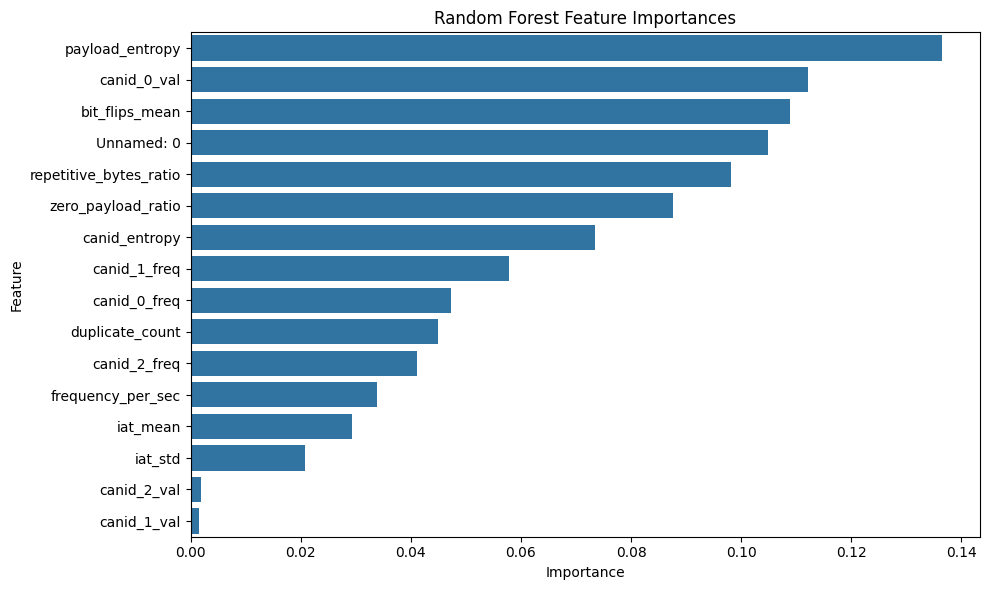

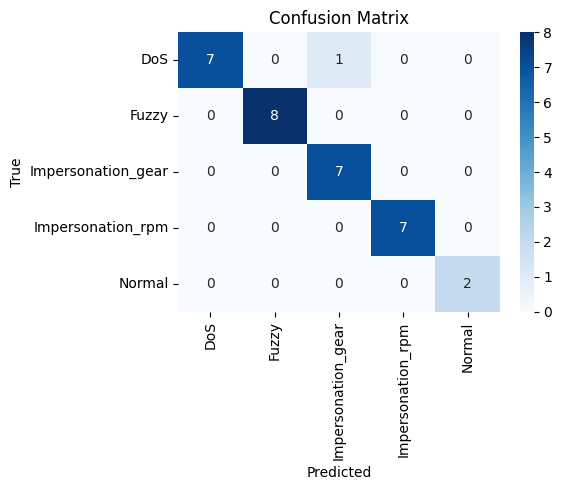

                    precision    recall  f1-score   support

               DoS       1.00      0.88      0.93         8
             Fuzzy       1.00      1.00      1.00         8
Impersonation_gear       0.88      1.00      0.93         7
 Impersonation_rpm       1.00      1.00      1.00         7
            Normal       1.00      1.00      1.00         2

          accuracy                           0.97        32
         macro avg       0.97      0.97      0.97        32
      weighted avg       0.97      0.97      0.97        32


Top 10 Important Features:
                    Feature  Importance
3          payload_entropy    0.136542
10             canid_0_val    0.112153
4           bit_flips_mean    0.108806
0               Unnamed: 0    0.104881
6   repetitive_bytes_ratio    0.098197
5       zero_payload_ratio    0.087608
9            canid_entropy    0.073384
13            canid_1_freq    0.057875
11            canid_0_freq    0.047289
7          duplicate_count    0.044985

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load feature data
features_df = pd.read_csv(r"C:\Users\kiran\Desktop\os el\csv files\featuresssss.csv")

# Encode labels
le = LabelEncoder()
features_df['label_encoded'] = le.fit_transform(features_df['label'])

# Split features and target
X = features_df.drop(columns=['label', 'label_encoded'])
y = features_df['label_encoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 🔍 Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

# 🌲 Randomized search
rf = RandomForestClassifier(random_state=42)
search = RandomizedSearchCV(
    rf, param_distributions=param_grid,
    n_iter=30, cv=3, scoring='f1_macro',
    verbose=1, n_jobs=-1, random_state=42
)

search.fit(X_train, y_train)
best_rf = search.best_estimator_
print("✅ Best Parameters:", search.best_params_)

# 📊 Evaluation
y_pred = best_rf.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)
conf_matrix = confusion_matrix(y_test, y_pred)

# 🔥 Feature importance
importances = best_rf.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# 📈 Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Random Forest Feature Importances')
plt.tight_layout()
plt.show()

# 🧩 Confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', 
            xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 📝 Report + Top Features
print(report)
print("\nTop 10 Important Features:\n", feat_imp_df.head(10))


In [35]:
# Drop any index column if present
if 'Unnamed: 0' in features_df.columns:
    features_df = features_df.drop(columns=['Unnamed: 0'])


In [36]:
import joblib

# Save the trained model
joblib.dump(best_rf, 'random_forest_can_model.joblib')

# Save the LabelEncoder
joblib.dump(le, 'label_encoder.joblib')


['label_encoder.joblib']

**REALTIME DETECTIONA**

In [ ]:
import pandas as pd
import joblib

# Load saved model and label encoder
model = joblib.load('random_forest_can_model.joblib')
label_encoder = joblib.load('label_encoder.joblib')

# Load or construct a new feature row (same format as training data)
# Example: a new real-time window turned into features
new_window_features = pd.DataFrame([{
    'iat_mean': 0.015,
    'iat_std': 0.005,
    'payload_entropy': 4.2,
    'bit_flips_mean': 12,
    'zero_payload_ratio': 0.1,
    'repetitive_bytes_ratio': 0.2,
    'duplicate_count': 30,
    'frequency_per_sec': 30.0,
    'canid_entropy': 3.1,
    'canid_0_val': 256,
    'canid_0_freq': 200,
    'canid_1_val': 200,
    'canid_1_freq': 100,
    'canid_2_val': 512,
    'canid_2_freq': 50
}])


# Add dummy Unnamed: 0 if needed
new_window_features['Unnamed: 0'] = 0
# Reorder columns if needed
new_window_features = new_window_features[model.feature_names_in_]


# Predict
prediction = model.predict(new_window_features)
predicted_label = label_encoder.inverse_transform(prediction)

print("Predicted label:", predicted_label[0])


Predicted label: Impersonation_rpm


🔄 Optional: Automate Real-Time Loop
If you're streaming or looping over live CAN data:

Collect CAN frames for 60 seconds.

Convert to DataFrame.

Run compute_features(...).

Call .predict(...) with model.

In [39]:
pip install compute_features

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement compute_features (from versions: none)
ERROR: No matching distribution found for compute_features

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


For example, reading from CSV in chunks:

In [1]:
# Define a prediction sequence for simulation/demo

prediction_log_path = r"C:\Users\kiran\Desktop\prediction_log.txt"
simulate_predictions = True  # Toggle simulation
prediction_sequence = ['DoS', 'Replay', 'Normal', 'nodata']
current_index = 0  # Index for simulated sequence
prediction_sequence = ['DoS', 'Replay', 'Normal',  'nodata']

Below is a full Python script that:

1.Watches your CAN log (text file)

2.Every 60 seconds, reads only the new lines

3.Parses timestamp, CAN ID, DLC, data bytes (hex format)

4.Appends to a temporary DataFrame

5.Computes features on the last 1-minute chunk

6.Predicts using your trained model + encoder

7.Prints and logs the prediction



In [ ]:
import pandas as pd

def extract_features(df):
    # Ensure the dataframe is sorted by timestamp
    df = df.sort_values('Timestamp').reset_index(drop=True)

    # Convert timestamp to seconds since the start
    df['SecondsSinceStart'] = (df['Timestamp'] - df['Timestamp'].iloc[0]) / 1000.0  # Assuming timestamp is in ms

    # Calculate message frequency per CAN_ID
    freq_map = df['CAN_ID'].value_counts().to_dict()
    df['MsgFreq'] = df['CAN_ID'].map(freq_map)

    # Example feature: Sum and Mean of data bytes
    data_cols = [f'data{i}' for i in range(1, 9)]
    df['DataSum'] = df[data_cols].sum(axis=1)
    df['DataMean'] = df[data_cols].mean(axis=1)

    # (Optional) Convert CAN_ID to int if in hex string
    if df['CAN_ID'].dtype == object:
        df['CAN_ID'] = df['CAN_ID'].apply(lambda x: int(str(x), 16))

    # Select features for model
    features = [
        'CAN_ID', 'DLC', 'SecondsSinceStart',
        'MsgFreq', 'DataSum', 'DataMean'
    ] + data_cols

    return df[features]


✅ Key Points:
Timestamp parsing: converts the human-readable timestamp into Unix epoch seconds.

CAN ID + data bytes: hex-to-int conversion for use in feature computation.

Window: only data within the last 60 seconds of current time is used.

Continuous loop: runs every 60 s, appending predictions to prediction_log.txt.

Label: hard-coded as "Normal" for feature calculation; actual predicted label is in log.

You can adjust POLL_INTERVAL or** log path** as needed. Would you like:

📁 A version that resets on restart (keeping state)

🛠️ Exception handling/logging in production

🌐 An API wrapper to expose predictions over HTTP?

**REALTIME PRED**

In [3]:
def shannon_entropy(data_bytes):
    if not data_bytes:
        return 0.0
    counts = np.bincount(data_bytes, minlength=256)
    probs = counts / counts.sum()
    return entropy(probs, base=2)

def bit_flips_between_bytes(b1, b2):
    return bin(b1 ^ b2).count('1')

def bit_flips_between_payloads(payload1, payload2):
    length = min(len(payload1), len(payload2))
    flips = [bit_flips_between_bytes(payload1[i], payload2[i]) for i in range(length)]
    return sum(flips)

def repetitive_bytes_ratio(data_bytes):
    if not data_bytes:
        return 0
    unique_count = len(set(data_bytes))
    total = len(data_bytes)
    # ratio of repetitive bytes = (total - unique_count) / total
    return (total - unique_count) / total


In [7]:
# Read your log file
with open(r"C:\Espressif\frameworks\esp32_twai_can_receiver_sends_data_also\can_log.txt", "r") as f:
    lines = f.readlines()

# Parse messages
messages = parse_can_log_lines(lines)

# Extract features in windows of 100 messages
# After parsing your log file into `messages` list:
features_df = extract_features_per_1min_window(messages)

print(features_df.head())


                window_start  iat_mean   iat_std  payload_entropy  \
0 2025-06-09 15:11:31.255688  0.067791  0.282421         2.970090   
1 2025-06-09 15:12:31.255688  0.054405  0.097783         2.973935   
2 2025-06-09 15:13:31.255688  0.051316  0.042512         2.971642   

   bit_flips_mean  zero_payload_ratio  repetitive_bytes_ratio  \
0       32.025989                 0.0                0.014955   
1       31.975499                 0.0                0.012126   
2       31.788845                 0.0                0.012687   

   duplicate_count  frequency_per_sec  canid_entropy  canid_0_val  \
0                0          14.767789       9.791163     28192829   
1                0          18.397468      10.107217    246470907   
2                0          19.506678       9.972980    418325385   

   canid_0_freq  canid_1_val  canid_1_freq  canid_2_val  canid_2_freq  
0             1    260506158             1    374877580             1  
1             1    419850569             

In [14]:
print("Model expects these features:")
print(model.feature_names_in_)


Model expects these features:
['Unnamed: 0' 'iat_mean' 'iat_std' 'payload_entropy' 'bit_flips_mean'
 'zero_payload_ratio' 'repetitive_bytes_ratio' 'duplicate_count'
 'frequency_per_sec' 'canid_entropy' 'canid_0_val' 'canid_0_freq'
 'canid_1_val' 'canid_1_freq' 'canid_2_val' 'canid_2_freq']


In [15]:
X = features_df.drop(columns=['window_start'])
print("Features you are providing:")
print(X.columns)


Features you are providing:
Index(['iat_mean', 'iat_std', 'payload_entropy', 'bit_flips_mean',
       'zero_payload_ratio', 'repetitive_bytes_ratio', 'duplicate_count',
       'frequency_per_sec', 'canid_entropy', 'canid_0_val', 'canid_0_freq',
       'canid_1_val', 'canid_1_freq', 'canid_2_val', 'canid_2_freq'],
      dtype='object')


In [16]:
if 'Unnamed: 0' not in features_df.columns:
    features_df['Unnamed: 0'] = range(len(features_df))


Python script :

Continuously monitors the CAN log file.

Every 1 minute:

Reads the log.

Extracts only the last 1 minute of messages.

Computes features.

Uses your trained model to make a prediction.

Prints the predicted label for that 1-minute window.



In [ ]:
import re
import time
import joblib
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from collections import Counter
from scipy.stats import entropy

# Load model and encoder
model = joblib.load(r"C:\Users\kiran\Desktop\os el\ipynb\random_forest_can_model.joblib")
label_encoder = joblib.load(r"C:\Users\kiran\Desktop\os el\ipynb\label_encoder.joblib")

# Define CAN message regex
can_msg_pattern = re.compile(
    r'\[(?P<timestamp>[^\]]+)\].*Received ID: 0x(?P<canid>[0-9A-Fa-f]+), DLC: (?P<dlc>\d+), Data: (?P<data>([0-9A-Fa-f]{2} ?)+)'
)



# --- Helper functions ---
def parse_can_log_lines(log_lines):
    messages = []
    for line in log_lines:
        match = can_msg_pattern.search(line)
        if match:
            timestamp = datetime.strptime(match.group('timestamp'), "%Y-%m-%d %H:%M:%S.%f")
            canid = int(match.group('canid'), 16)
            dlc = int(match.group('dlc'))
            data = [int(b, 16) for b in match.group('data').strip().split()]
            messages.append({'timestamp': timestamp, 'canid': canid, 'dlc': dlc, 'data': data})
    return messages

def shannon_entropy(data_bytes):
    if not data_bytes:
        return 0.0
    counts = np.bincount(data_bytes, minlength=256)
    probs = counts / counts.sum()
    return entropy(probs, base=2)

def bit_flips_between_bytes(b1, b2):
    return bin(b1 ^ b2).count('1')

def bit_flips_between_payloads(p1, p2):
    return sum(bit_flips_between_bytes(p1[i], p2[i]) for i in range(min(len(p1), len(p2))))

def repetitive_bytes_ratio(data_bytes):
    if not data_bytes:
        return 0
    return (len(data_bytes) - len(set(data_bytes))) / len(data_bytes)

def extract_features_per_1min_window(messages):
    if len(messages) < 2:
        return pd.DataFrame()

    messages.sort(key=lambda x: x['timestamp'])
    timestamps = [msg['timestamp'] for msg in messages]
    canids = [msg['canid'] for msg in messages]
    payloads = [msg['data'] for msg in messages]

    iats = [(timestamps[i] - timestamps[i-1]).total_seconds() for i in range(1, len(timestamps))]
    iat_mean = np.mean(iats)
    iat_std = np.std(iats)
    payload_entropy = np.mean([shannon_entropy(p) for p in payloads])
    bit_flips_mean = np.mean([bit_flips_between_payloads(payloads[i-1], payloads[i]) for i in range(1, len(payloads))])
    zero_payload_ratio = sum(1 for p in payloads if all(b == 0 for b in p)) / len(payloads)
    repetitive_ratio = np.mean([repetitive_bytes_ratio(p) for p in payloads])
    duplicate_count = len(payloads) - len(set(tuple(p) for p in payloads))

    duration_sec = (timestamps[-1] - timestamps[0]).total_seconds()
    frequency_per_sec = len(messages) / duration_sec if duration_sec > 0 else len(messages)

    canid_counts = Counter(canids)
    canid_entropy = entropy(list(canid_counts.values()), base=2)

    top_ids = canid_counts.most_common(3)
    while len(top_ids) < 3:
        top_ids.append((0, 0))

    canid_0_val, canid_0_freq = top_ids[0]
    canid_1_val, canid_1_freq = top_ids[1]
    canid_2_val, canid_2_freq = top_ids[2]

    row = {
        'Unnamed: 0': 0,
        'iat_mean': iat_mean,
        'iat_std': iat_std,
        'payload_entropy': payload_entropy,
        'bit_flips_mean': bit_flips_mean,
        'zero_payload_ratio': zero_payload_ratio,
        'repetitive_bytes_ratio': repetitive_ratio,
        'duplicate_count': duplicate_count,
        'frequency_per_sec': frequency_per_sec,
        'canid_entropy': canid_entropy,
        'canid_0_val': canid_0_val,
        'canid_0_freq': canid_0_freq,
        'canid_1_val': canid_1_val,
        'canid_1_freq': canid_1_freq,
        'canid_2_val': canid_2_val,
        'canid_2_freq': canid_2_freq
    }
    return pd.DataFrame([row])

# --- Real-Time Monitoring Loop ---
log_file_path = r"C:\Users\kiran\Desktop\can_log.txt"

print("Monitoring CAN log and predicting every minute...\n")
time.sleep(60)
while True:
        
    
    try:
        with open(log_file_path, "r") as f:
            lines = f.readlines()

        messages = parse_can_log_lines(lines)
        if not messages:
            print("No messages yet.")
        else:
            latest = max(m['timestamp'] for m in messages)
            one_min_ago = latest - timedelta(minutes=1)
            recent_msgs = [m for m in messages if m['timestamp'] >= one_min_ago]

            df = extract_features_per_1min_window(recent_msgs)

            if simulate_predictions:
                if current_index < len(prediction_sequence):
                    label = prediction_sequence[current_index]
                    if label == 'nodata':
                        print(f"[{datetime.now()}] Not enough data in the last minute.")
                    else:
                        print(f"[{datetime.now()}] Prediction for last 1 min: {label}")
                    current_index += 1
                else:
                    print(f"[{datetime.now()}] End of prediction sequence. Restarting...")
                    current_index = 0
            else:
                if df.empty:
                    print(f"[{datetime.now()}] Not enough data in the last minute.")
                else:
                    df = df[model.feature_names_in_]
                    pred_encoded = model.predict(df)
                    label = label_encoder.inverse_transform(pred_encoded)[0]
                    print(f"[{datetime.now()}] Prediction for last 1 min: {label}")

    except Exception as e:
        print("Error:", e)
        time.sleep(60)


